In [1]:
from metabolinks import align, read_aligned_spectra, read_spectra_from_xcel
from metabolinks.similarity import mz_similarity
import pandas as pd
from metabolinks import AlignedSpectra
import numpy as np

### Similarity analysis with Metabolights data: 
#### Application of metabolomics and molecular networking in investigating the chemical profile and antitrypanosomal activity of British bluebells (Hyacinthoides non-scripta)
#### Bluebell saponins: Application of metabolomics and molecular networking

Article link: https://www.nature.com/articles/s41598-019-38940-w

Metabolights dataset link: https://www.ebi.ac.uk/metabolights/MTBLS797

Five different tissues of the bluebells plant with different amounts of replicates (unbalanced dataset):
- Bulb - 15 samples.
- Leaves - 6 samples.
- Scapes - 8 samples.
- Shoot - 4 samples (limiting group - 4-fold cross-validation used).
- Flower - 8 samples.

Metabolomics approach:
- Liquid Chromatography – High Resolution Fourier Transform Mass Spectrometry (LC-HRFTMS) Analysis or Orbitrap (both are done).
- No reference masses described/seen so far.
- Obtained in ESI positive and negative modes.
- m/z tolerance used was 0.001, peaks detected above 5.00E4 and minimum time span and tR tolerance was 0.2 minutes. Mass detection performed using centroid mass detector with a noise level set at 1.00E4. Peaks were filtered using FTMS shoulder peaks filter with a mass resolution of 50,000 and the Gaussian peak model.

Data characteristics:
- Large dataset with seemingly no treatment/normalization done beforehand (no normalization mentioned in the paper, reference to a normalization in the Metabolights notes) with around 5600 peaks - no a lot of filtering of m/z peaks was done (peaks had to have 20 times the intensity in relation to a blank solvent). Therefore there seems to be no favoring to binary or conventional methods. 

All further changes to code will first be implemented on the original similarity_analysis. This is an altered version of said original.

To better understand the functions used outside of normal Python packages, see scaling.py and multianalysis.py where they are better described and try to say what is happening in each block of code.

## Similarity analysis

aligned_HILIC_NEG / all names ending with neg = dataset or derived from the dataset (HILIC_NEG part of name is just and artifact of a previous notebook - no meaning).

#### Read aligned data and transformation into an AlignedSpectra object with zeros as missing values

In [2]:
file = pd.read_table('Metabolights/m_bluebells_metabolite_profiling_mass_spectrometry_v2_maf.tsv', header=[0], sep='\t')

file = file[file.columns[21:]]
file = file.drop(columns = ['MeOH'])
#file = file[file.columns!= 'MeOH']
#for i in range(len(file)):
    #for j in range(37):
        #if type(file.iloc[i,j]) != np.float64:
            #file.iloc[i,j] = np.float64(file.iloc[i,j])
aligned_file = AlignedSpectra(file, labels=["Flower","Leaf","Leaf","Leaf","Flower","Leaf","Flower","Bulb","Shoot","Bulb", 
                                            "Shoot","Shoot","Shoot","Bulb","Flower","Bulb","Flower","Bulb","Flower","Bulb",
                                            "Flower","Bulb","Bulb","Scape","Bulb","Scape","Bulb","Scape","Bulb",
                                            "Scape","Leaf","Leaf","Flower","Bulb","Scape","Bulb","Scape","Bulb","Scape",
                                            "Bulb","Scape"])

#Replacing 0 values with missing number values for better missing value imputation and feature removal
aligned_HILIC_NEG = aligned_file.data.replace({0:np.nan})
aligned_HILIC_NEG = AlignedSpectra(aligned_HILIC_NEG, labels=aligned_file.labels)

In [3]:
aligned_HILIC_NEG.data

,Dotsha40,Dotsha19,Dotsha18,Dotsha17,Dotsha39,Dotsha16,Dotsha38,Dotsha11,Dotsha33,Dotsha10,...,Dotsha20,Dotsha41,Dotsha04,Dotsha26,Dotsha03,Dotsha25,Dotsha02,Dotsha24,Dotsha01,Dotsha23
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.640000e+07,1.840000e+08,6.970000e+07,4.460000e+07,4.590000e+07,6.227750e+06,5.901142e+06,5.726595e+06,1.840000e+08,6.763794e+06,...,6.046481e+06,4.240000e+07,7.685873e+06,1.850000e+07,5.834345e+06,1.430000e+09,5.354917e+06,1.830000e+08,5.889334e+06,1.850000e+08
2,8.095649e+06,7.804774e+06,7.988827e+06,1.270000e+07,6.586657e+06,1.100000e+07,9.402276e+06,1.180000e+07,1.270000e+07,5.915478e+06,...,8.175683e+06,5.061908e+04,2.550000e+07,1.210000e+07,3.780000e+07,1.300000e+07,1.630000e+07,1.620000e+07,2.400000e+07,2.990000e+07
3,1.202926e+06,1.151827e+06,1.183014e+06,1.872705e+06,9.765677e+05,1.604615e+06,1.384481e+06,1.739213e+06,1.862370e+06,8.683881e+05,...,1.183837e+06,3.910975e+03,3.988813e+06,1.749770e+06,5.683933e+06,1.911860e+06,2.404521e+06,2.390582e+06,3.516198e+06,4.851814e+06
4,3.098305e+06,4.168573e+06,2.928556e+06,1.237206e+06,3.382604e+06,2.168892e+06,3.090600e+06,1.627986e+06,3.015047e+06,1.753696e+06,...,3.277548e+06,2.834835e+06,5.809229e+05,3.474607e+06,1.294930e+05,2.170068e+06,1.118008e+05,2.456434e+06,2.237740e+04,1.514553e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5613,9.174162e+06,2.680839e+04,9.408837e+03,1.620303e+04,1.600687e+06,NaN,3.336555e+06,3.065502e+05,1.842542e+05,1.205321e+05,...,5.335112e+04,1.020000e+07,3.056013e+05,2.617688e+06,8.023726e+05,3.098874e+06,3.217826e+05,4.390905e+06,1.970467e+05,9.847340e+06
5614,1.463378e+05,4.080801e+03,3.088507e+03,1.961747e+04,8.449314e+04,5.089503e+03,4.670739e+05,NaN,2.609991e+03,2.074986e+03,...,3.613783e+03,3.080303e+05,1.688112e+03,3.645795e+05,9.304752e+03,7.595137e+04,2.683473e+03,1.502761e+04,NaN,2.414120e+04
5615,6.645727e+06,1.918537e+04,6.280238e+03,2.135262e+04,1.182814e+06,NaN,1.936013e+06,2.329574e+05,1.047526e+05,8.538362e+04,...,9.500124e+03,7.735829e+06,2.215141e+05,1.909581e+06,5.868644e+05,2.245569e+06,2.361279e+05,3.378023e+06,1.481795e+05,7.366095e+06
5616,7.748957e+04,1.065554e+06,7.640567e+05,5.741906e+05,3.450680e+04,1.106852e+04,1.232252e+05,NaN,2.198583e+05,NaN,...,8.170254e+05,1.313272e+05,NaN,1.580090e+05,NaN,2.285876e+05,NaN,1.022654e+05,NaN,3.559817e+05


#### Compute m/z similarities

In [4]:
sim_pos = mz_similarity(aligned_HILIC_NEG)

In [5]:
print(sim_pos)


Sample similarity, counts of common peaks
          Dotsha40  Dotsha19  Dotsha18  Dotsha17  Dotsha39  Dotsha16  \
Dotsha40      4184      3817      3842      3890      4021      3804   
Dotsha19      3817      4050      3911      3890      3792      3774   
Dotsha18      3842      3911      4071      3933      3813      3833   
Dotsha17      3890      3890      3933      4129      3856      3888   
Dotsha39      4021      3792      3813      3856      4118      3766   
Dotsha16      3804      3774      3833      3888      3766      4013   
Dotsha38      3992      3835      3839      3869      3984      3780   
Dotsha11      3637      3572      3600      3654      3598      3577   
Dotsha33      3681      3615      3642      3636      3660      3600   
Dotsha10      3566      3487      3518      3590      3532      3503   
Dotsha32      3498      3472      3499      3476      3475      3448   
Dotsha31      3528      3476      3511      3502      3491      3456   
Dotsha30      3735   

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import seaborn as sns
import pandas as pd

In [7]:
dfpos = pd.DataFrame(sim_pos.sample_similarity_jaccard,
                     columns=sim_pos.sample_names,
                     index=sim_pos.sample_names)

Sample similarity, positive mode, samples are shuffled


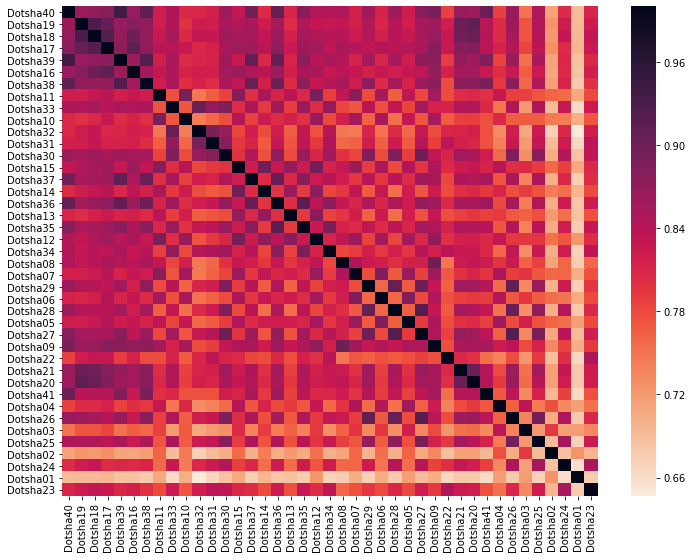

In [8]:
f, ax = plt.subplots(figsize=(12, 9))

print('Sample similarity, positive mode, samples are shuffled')
hm = sns.heatmap(dfpos, annot=False, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [9]:
dfpos = pd.DataFrame(sim_pos.label_similarity_jaccard,
                     columns=sim_pos.unique_labels,
                     index=sim_pos.unique_labels)

Label similarity, positive mode


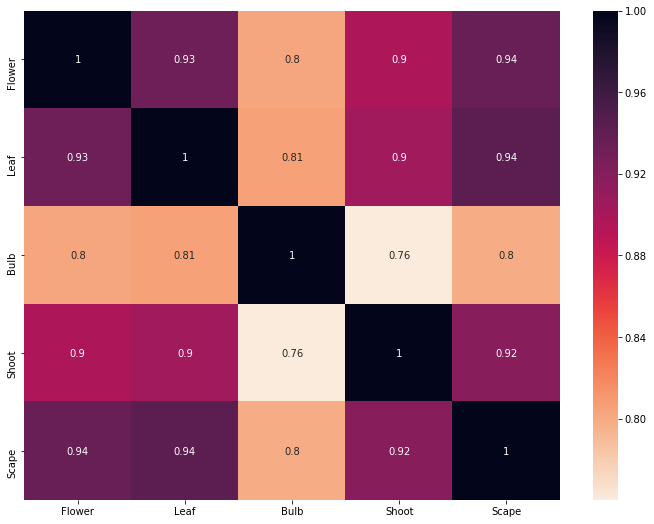

In [10]:
f, ax = plt.subplots(figsize=(12, 9))

print('Label similarity, positive mode')
hm = sns.heatmap(dfpos, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

#### Doing... Experiments with scipy functions...

In [11]:
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier

In [12]:
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    df = df.copy()
    df[df.notnull()] = 1
    df[df.isnull()] = 0
    return df
aligned_01 = df_to_bool(aligned_HILIC_NEG.data)
# confirm it is 0's and 1's
#aligned_01

In [13]:
jdist = dist.pdist(aligned_01.T, metric='jaccard')
print(dist.squareform(jdist))
print('------------------------------------')
sim = mz_similarity(aligned_HILIC_NEG)
jsim = sim.sample_similarity_jaccard
jdist = 1 - jsim
print(jdist)

[[0.         0.1358388  0.12939044 ... 0.19475138 0.30976287 0.18982973]
 [0.1358388  0.         0.07102138 ... 0.17906922 0.30729053 0.17789821]
 [0.12939044 0.07102138 0.         ... 0.17194891 0.30640608 0.16733633]
 ...
 [0.19475138 0.17906922 0.17194891 ... 0.         0.34171531 0.14668013]
 [0.30976287 0.30729053 0.30640608 ... 0.34171531 0.         0.32368242]
 [0.18982973 0.17789821 0.16733633 ... 0.14668013 0.32368242 0.        ]]
------------------------------------
[[0.         0.1358388  0.12939044 ... 0.19475138 0.30976287 0.18982973]
 [0.1358388  0.         0.07102138 ... 0.17906922 0.30729053 0.17789821]
 [0.12939044 0.07102138 0.         ... 0.17194891 0.30640608 0.16733633]
 ...
 [0.19475138 0.17906922 0.17194891 ... 0.         0.34171531 0.14668013]
 [0.30976287 0.30729053 0.30640608 ... 0.34171531 0.         0.32368242]
 [0.18982973 0.17789821 0.16733633 ... 0.14668013 0.32368242 0.        ]]


## Wrapping up in a function...

Bluebell dendogram, Jaccard distance


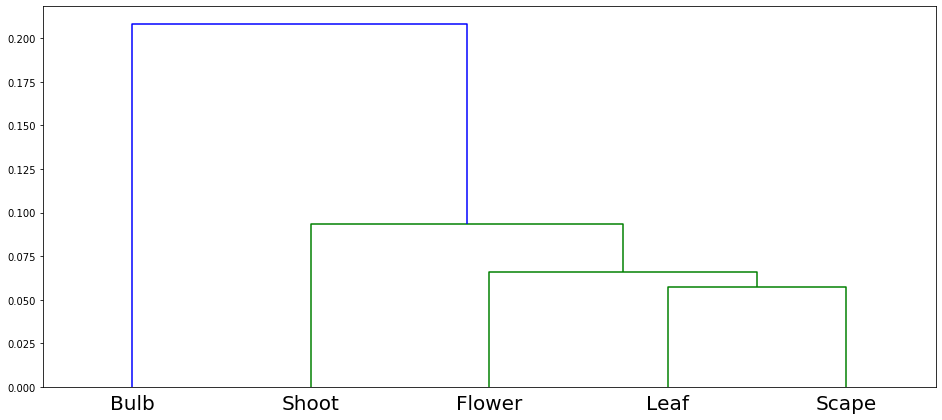

In [14]:
print('Bluebell dendogram, Jaccard distance')
jdist = dist.squareform(1 - sim_pos.label_similarity_jaccard)
Z = hier.linkage(jdist, method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z, labels=sim_pos.unique_labels,
                     leaf_font_size=20,
                     above_threshold_color='b')
fig.savefig('dendo_cultivars_jaccard_positive.pdf')

In [15]:
print(hier.cophenet(Z,jdist)[0])

0.9815046181723147


### Other Binary Similarity Analysis Methods

In [16]:
aligned_neg = df_to_bool(aligned_HILIC_NEG.data)

Creating the colours label for all dendrograms (negative and positive have the same labels):

In [17]:
label_colors = {}
colours = cm.get_cmap('nipy_spectral', 41)
col_lbl = colours(range(41))
for i in range(len(col_lbl)):
    label_colors[aligned_HILIC_NEG.labels[1*i]] = col_lbl[i]

Bluebell dendogram, Binary methods


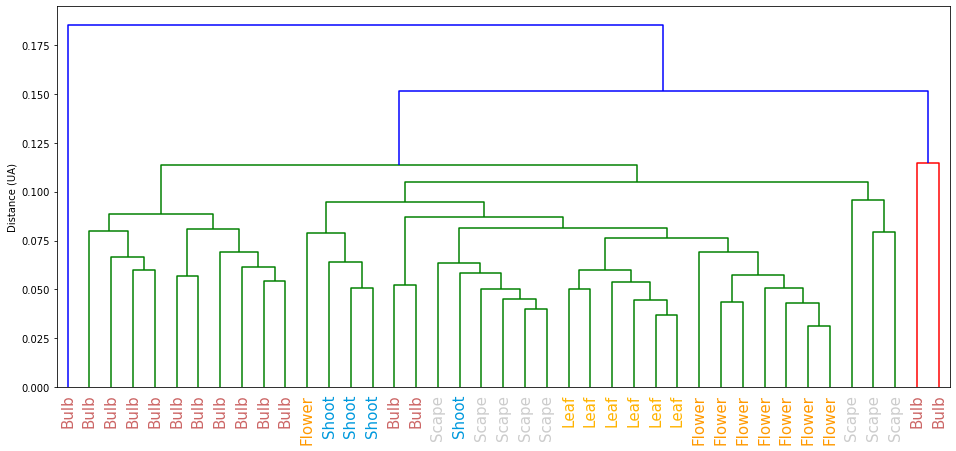

In [18]:
#Apply one of the following:
#dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule
#kulsinski, rusellrao

print('Bluebell dendogram, Binary methods')
Zdice_neg = hier.linkage(aligned_neg.T, metric = 'dice', method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Zdice_neg, labels=aligned_HILIC_NEG.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

### Non-binary Similarity Analysis

All samples need to have missing value imputation (removing features is optional) with the function NaN_Imputation of scaling.py (replace missing features with half of the minimum intensity of the full dataset).

After that, the rest of the data processing can vary where 3 different processing emthods were applied in different combinations:

##### Normalization by a references feature (Norm_feat from scaling.py) - N;
##### Glog transformation/ log2 transformation (glog from scaling.py) - G;
##### Pareto Scaling (ParetoScal from scaling.py) - P.
Three combinations were used and compared: No treatment (Imp), only Pareto Scaling (P) and glog transformation and Pareto Scaling (NGP).

In [19]:
import scaling as sca
import numpy as np

#### Analysis

Since the state of the data we have is unknown among the different Metabolights datasets (some are known to have performed some kind of normalization, others there isn't any certainties) and since the reference features also are, for the most part, not known, normalization procedures aren't applied here as they were in previous dataset and the "absence of treatment" in the data is also tested since most of these dataset already suffered some kind of treatment.

3 types of processing:

Euc_Imp_pos - Missing Value Imputation.

Euc_P_pos - Missing Value Imputation and Pareto Scaling.

Euc_NGP_pos - Missing Value Imputation, glog transformation and Pareto Scaling.

In [20]:
#Euc_P_neg
Imputated_neg = sca.NaN_Imputation(aligned_HILIC_NEG, 0)
Euc_P_neg = sca.ParetoScal(Imputated_neg)

Bluebell dendogram, Euclidean distance, NaN Imputation


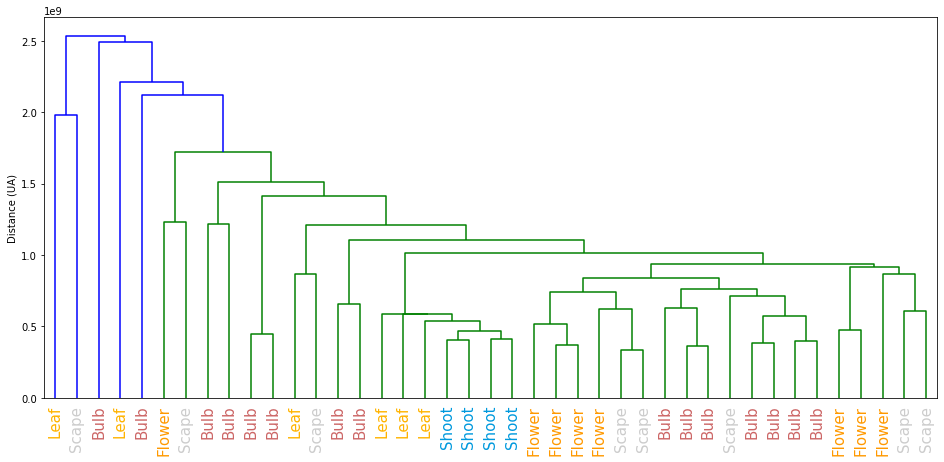

In [21]:
#Measure Euclidean distances
dist_euc_Imp_neg = dist.pdist(Imputated_neg.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Bluebell dendogram, Euclidean distance, NaN Imputation')
Z_euc_Imp_neg = hier.linkage(dist_euc_Imp_neg, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_Imp_neg, labels=Imputated_neg.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

Bluebell dendogram, Euclidean distance, NaN Imputation and Pareto Scaling


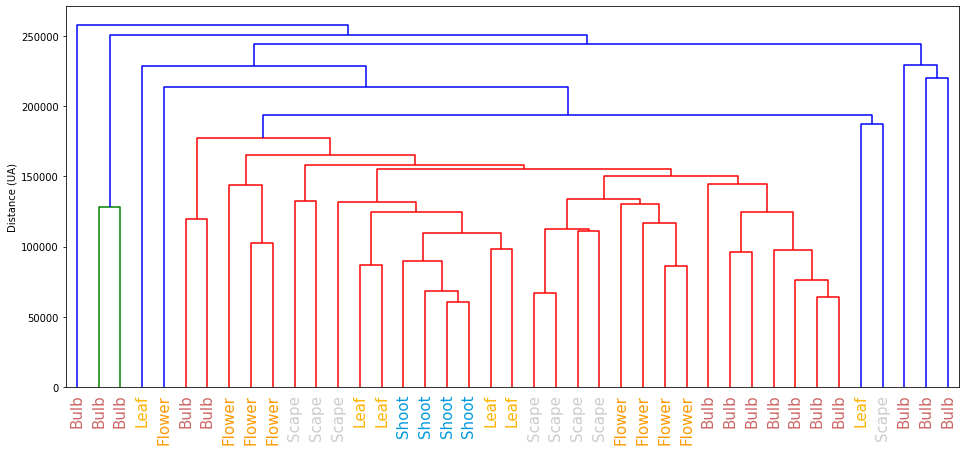

In [22]:
#Measure Euclidean distances
dist_euc_P_neg = dist.pdist(Euc_P_neg.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Bluebell dendogram, Euclidean distance, NaN Imputation and Pareto Scaling')
Z_euc_P_neg = hier.linkage(dist_euc_P_neg, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_P_neg, labels=Euc_P_neg.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [23]:
#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
print(hier.cophenet(Z_euc_P_neg,dist_euc_P_neg)[0]) #method average seems to lead to higher coefficients

0.9201325650802585


In [24]:
#Euc_NGP_neg
glog_neg = sca.glog(Imputated_neg, 0)
Euc_NGP_neg = sca.ParetoScal(glog_neg)

Bluebell dendogram, Euclidean distance, NaN Imputation, Transformed and Pareto Scaling


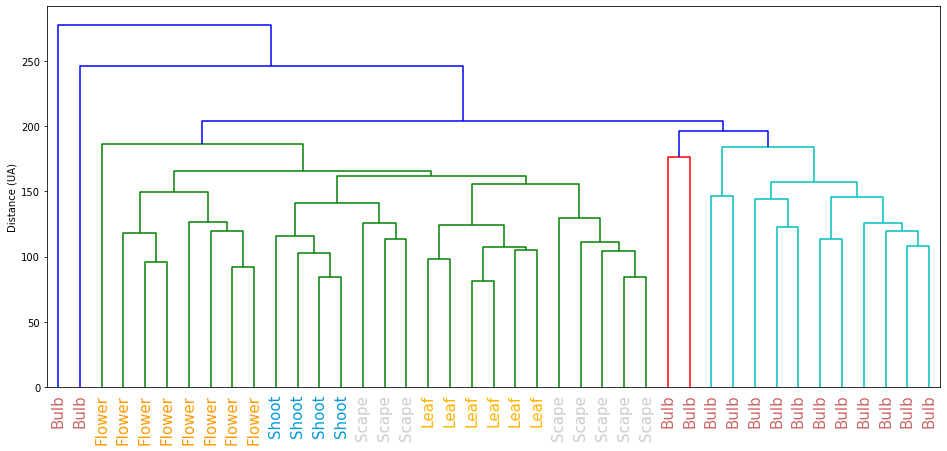

In [25]:
#Measure Euclidean distances
dist_euc_NGP_neg = dist.pdist(Euc_NGP_neg.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Bluebell dendogram, Euclidean distance, NaN Imputation, Transformed and Pareto Scaling')
Z_euc_NGP_neg = hier.linkage(dist_euc_NGP_neg, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_NGP_neg, labels=Euc_NGP_neg.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [26]:
print(hier.cophenet(Z_euc_NGP_neg,dist_euc_NGP_neg)[0]) 

0.8926682242893968


### Comparing Dendrograms

#### Two methods so far: Baker's Gamma Correlation and Cophenetic Correlation Coefficient

#### Examples of procedure with these methods

In [27]:
import numpy as np
import scipy.stats as stats
import multianalysis as ma

#### Baker's method

Use of the mergerank function from multianalysis to create a 'rank' of the iteration number two samples were linked to the same cluster.

In [28]:
euclidean = (Z_euc_Imp_neg, Z_euc_P_neg, Z_euc_NGP_neg)
dist_euclidean = (dist_euc_Imp_neg, dist_euc_P_neg, dist_euc_NGP_neg)

K_euc = []
S_euc = []
Coph_euc = []

for i in range(len(euclidean)):
    K_euc.append(ma.mergerank(euclidean[i])) #Mergerank
    S_euc.append(K_euc[i][K_euc[i]!=0]) #Both reshape to a 1D array (needed for spearman correlation) and take out 0's 
    Coph_euc.append(hier.cophenet(euclidean[i], dist_euclidean[i])) #Matrix of Cophenetic distances

#### Examples

According to Original Paper (Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors)

In [29]:
print('Pair of samples\tKendall Correlation \tp-value')
print('Imp_neg-P_neg  \t', stats.kendalltau(S_euc[0],S_euc[1])[0], '\t', stats.kendalltau(S_euc[0],S_euc[1])[1])
print('Imp_neg-NGP_neg\t', stats.kendalltau(S_euc[0],S_euc[2])[0], '\t', stats.kendalltau(S_euc[0],S_euc[2])[1])

Pair of samples	Kendall Correlation 	p-value
Imp_neg-P_neg  	 0.5556372384273666 	 8.032725601734389e-214
Imp_neg-NGP_neg	 0.1555600211977252 	 4.527906434631467e-17


According to the explanation given in the R package dendextend

In [30]:
print('Pair of samples\tSpearman Correlation \tp-value')
print('Imp_neg-P_neg  \t', stats.spearmanr(S_euc[0],S_euc[1])[0], '\t', stats.spearmanr(S_euc[0],S_euc[1])[1])
print('Imp_neg-NGP_neg\t', stats.spearmanr(S_euc[0],S_euc[2])[0], '\t', stats.spearmanr(S_euc[0],S_euc[2])[1])

Pair of samples	Spearman Correlation 	p-value
Imp_neg-P_neg  	 0.7292246551259054 	 3.4578182938675225e-272
Imp_neg-NGP_neg	 0.1957849725324691 	 1.2423122579042311e-15


#### Cophenetic Correlation Coefficient

In [31]:
#Acho que se pode aplicar logo a função np.corrcoef visto os elementos que vêm da função cophenet estão sempre na mesma ordem 
#uns em relação aos outros.

In [32]:
print('Pair of samples\tPearson Correlation \tp-value')
print('Imp_neg-P_neg  \t', stats.pearsonr(Coph_euc[0][1],Coph_euc[1][1])[0], '\t', stats.pearsonr(Coph_euc[0][1],Coph_euc[1][1])[1])
print('Imp_neg-NGP_neg\t', stats.pearsonr(Coph_euc[0][1],Coph_euc[2][1])[0], '\t', stats.pearsonr(Coph_euc[0][1],Coph_euc[2][1])[1])

Pair of samples	Pearson Correlation 	p-value
Imp_neg-P_neg  	 0.6626133778140488 	 8.539258151001004e-105
Imp_neg-NGP_neg	 0.2495296417045466 	 4.18245834351218e-13


### Comparison of dendrograms made with all binary metrics and euclidean distances 

#### Correlations between all pairs using all 3 methods

In [33]:
#9 binary methods accepted in pdist (scipy.spatial.distances.pdist)
binary = ('jaccard', 'hamming', 'yule')

In [34]:
#Application of all "single" steps needed presented in the examples above with every distance metric.
#Negative mode
Z_neg = []
K_neg = []
S_neg = []
Coph_neg = []

for i in range(len(binary)):
    Z_neg.append(hier.linkage(aligned_neg.T, metric = binary[i], method='average')) #Z
    K_neg.append(ma.mergerank(Z_neg[i])) #Mergerank
    S_neg.append(K_neg[i][K_neg[i]!=0]) #Eliminating 0's
    Coph_neg.append(hier.cophenet(Z_neg[i], dist.pdist(aligned_neg.T, metric = binary[i]))) #Cophenetic

In [35]:
#Creation of a list with all the "rank" values (in order) for the different metrics: 
#Negative Euclideans, Positive Euclideans, Negative Binaries, Positive Binaries
S = []
S.extend(S_euc)
S.extend(S_neg)
#Creation of a list with all the returns from the function cophenetic for the different metrics: 
#Negative Euclideans, Positive Euclideans, Negative Binaries, Positive Binaries
Coph = []
Coph.extend(Coph_euc)
Coph.extend(Coph_neg)

Creation of all dataframes needed to store all correlation coeficients and respective p-values fot all three methods

In [36]:
#Column names and row names for the dataframes
colnames = ['euc_Imp_neg', 'euc_P_neg', 'euc_NGP_neg','jaccard_neg', 'hamming_neg', 'yule_neg', ]

In [37]:
df_K = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #K - Kendall (Baker)
df_S = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #S - Spearman (Baker)
df_C = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #C - Cophenetic Correlation
df_K_p = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #p-values of K method
df_S_p = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #p-values of S method
df_C_p = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #p-values of C method

In [38]:
#Calculation of correlation coefficient for each method
for i in range(len(S)):
    for j in range(len(S)):
        df_K.iloc[i,j] = stats.kendalltau(S[i],S[j])[0] #Correlation coefficient
        df_S.iloc[i,j] = stats.spearmanr(S[i],S[j])[0] #Correlation coefficient
        df_C.iloc[i,j] = stats.pearsonr(Coph[i][1],Coph[j][1])[0] #Correlation coefficient
        df_K_p.iloc[i,j] = stats.kendalltau(S[i],S[j])[1] #p-value
        df_S_p.iloc[i,j] = stats.spearmanr(S[i],S[j])[1] #p-value
        df_C_p.iloc[i,j] = stats.pearsonr(Coph[i][1],Coph[j][1])[1] #p-value
        
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,len(S)))* np.nan, columns = colnames, index=[''])
lineV = pd.concat([line.iloc[:,:3], pd.DataFrame(np.empty((1,1))* np.nan, columns =[''], index = ['']), line.iloc[:,3:]], axis = 1)
df_KI = pd.concat([df_K.iloc[:3], line, df_K.iloc[3:]])
df_KI = pd.concat([df_KI.iloc[:,:3], lineV.T, df_KI.iloc[:,3:]], axis = 1)
df_SI = pd.concat([df_S.iloc[:3], line, df_S.iloc[3:]])
df_SI = pd.concat([df_SI.iloc[:,:3], lineV.T, df_SI.iloc[:,3:]], axis = 1)
df_CI = pd.concat([df_C.iloc[:3], line, df_C.iloc[3:]])
df_CI = pd.concat([df_CI.iloc[:,:3], lineV.T, df_CI.iloc[:,3:]], axis = 1)

### Heatmaps of the correlation coeficients for the 3 methods

Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 3: Euclidean_DataProcessing_Mode; Last 3: BinaryMetric_Mode


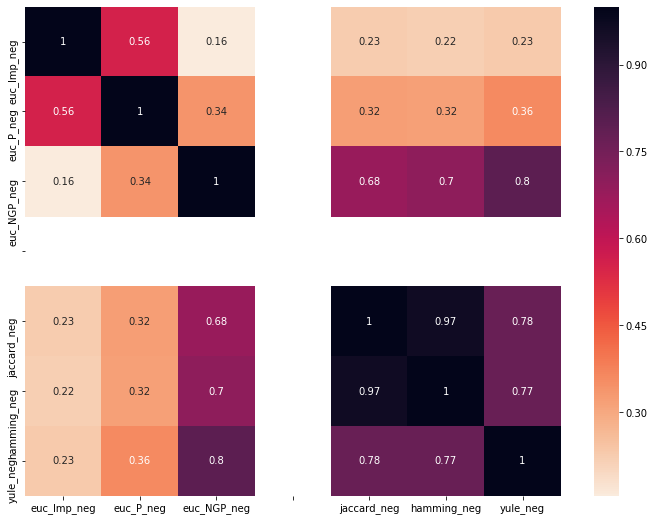

In [39]:
f, ax = plt.subplots(figsize=(12, 9))

print('Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 3: Euclidean_DataProcessing_Mode; Last 3: BinaryMetric_Mode')
hm = sns.heatmap(df_KI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
#plt.text(3,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
#plt.text(13.2,3,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
#plt.text(10,-0.2,'Binaries', fontsize = 15, horizontalalignment='center')
#plt.text(13.2,10,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 3: Euclidean_DataProcessing_Mode; Last 3: BinaryMetric_Mode


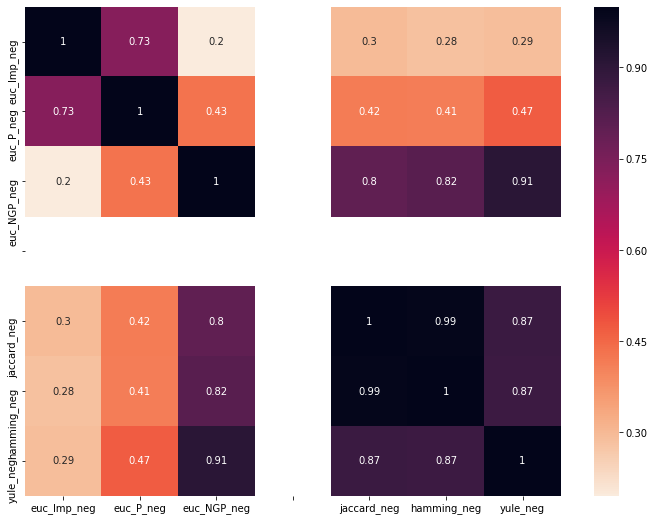

In [40]:
f, ax = plt.subplots(figsize=(12, 9))

print('Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 3: Euclidean_DataProcessing_Mode; Last 3: BinaryMetric_Mode')
hm = sns.heatmap(df_SI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
#plt.text(3,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
#plt.text(13.2,3,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
#plt.text(10,-0.2,'Binaries', fontsize = 15, horizontalalignment='center')
#plt.text(13.2,10,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 3: Euclidean_DataProcessing_Mode; Last 3: BinaryMetric_Mode


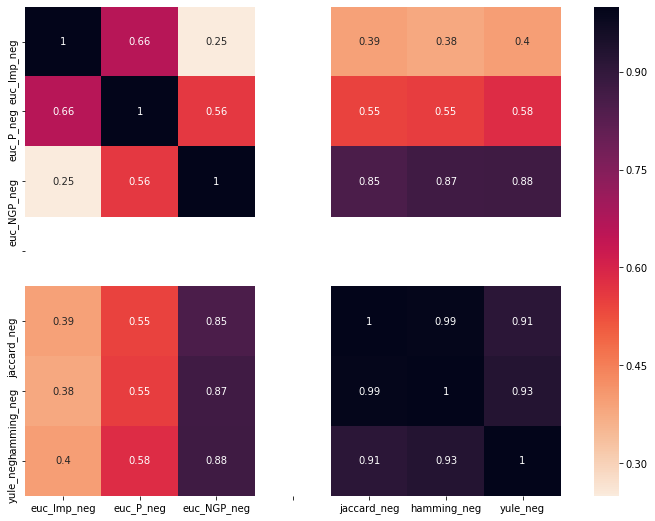

In [41]:
f, ax = plt.subplots(figsize=(12, 9))

print('Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 3: Euclidean_DataProcessing_Mode; Last 3: BinaryMetric_Mode')
hm = sns.heatmap(df_CI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
#plt.text(3,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
#plt.text(13.2,3,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
#plt.text(10,-0.2,'Binaries', fontsize = 15, horizontalalignment='center')
#plt.text(13.2,10,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

### Hierarchical clustering of the correlation coeficients of dendrograms made with different distance metrics with each other

Colours for these labels (groups: euclidean_neg, euclidean_pos, neg_binary, pos_binary)

Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode


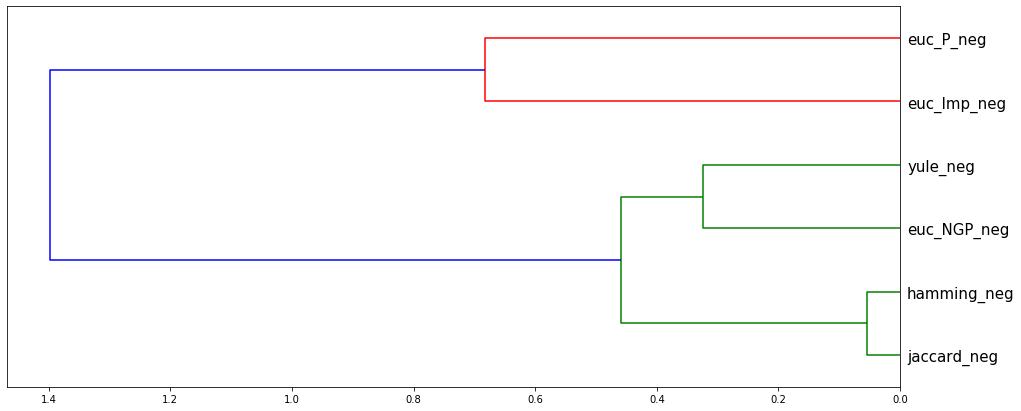

In [42]:
print('Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode')
Z_K = hier.linkage(df_K, metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_K, labels=df_K.columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')

Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode


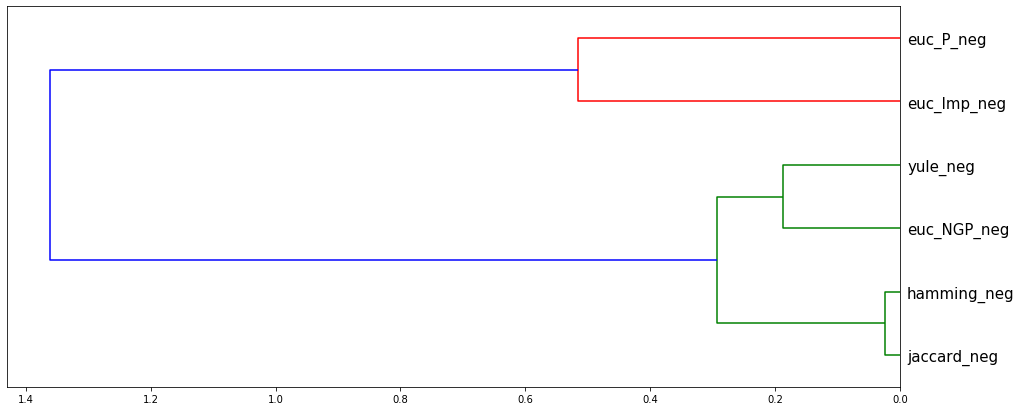

In [43]:
print('Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode')
Z_S = hier.linkage(df_S, metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_S, labels=df_S.columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')

Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode


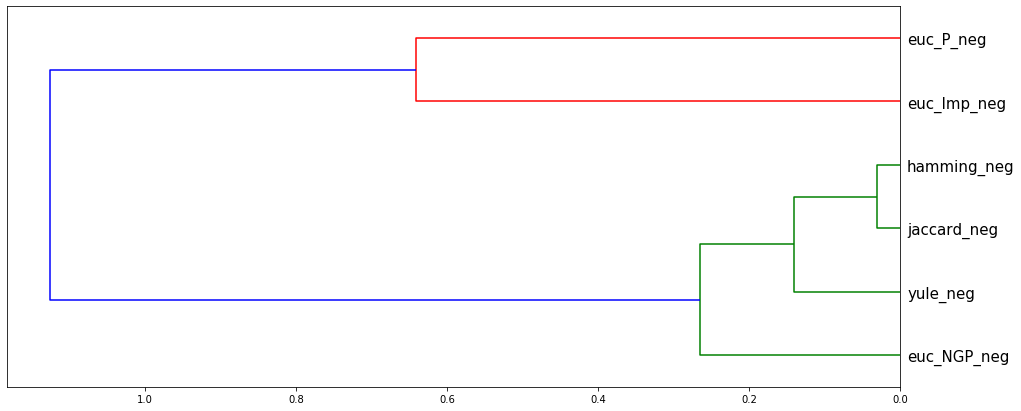

In [44]:
print('Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode')
Z_C = hier.linkage(df_C, metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_C, labels=df_C.columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')

### Distance discrimination of all methods applied (and shown in previous heatmap/dendrogram).

In [45]:
#Preparing Z linkage matrices
Z = []
Z.extend(euclidean)
Z.extend(Z_neg)

In [46]:
disc_average = np.zeros((1,6))
disc_median = np.zeros((1,6))
disc_correct = np.zeros((1,6))
for i in range(len(Z)):
    discrim = sca.dist_discrim(aligned_HILIC_NEG, Z[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = sca.dist_discrim(aligned_HILIC_NEG, Z[i], 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:3], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances average']).T, disc_average.iloc[:,3:]], axis = 1)
disc_median = pd.concat([disc_median.iloc[:,:3], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances median']).T, disc_median.iloc[:,3:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:3], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,3:]], axis = 1)

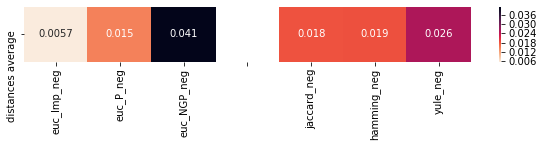

In [47]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
#plt.text(3,-0.2,'Conventional', fontsize  = 12, horizontalalignment='center')
#plt.text(10,-0.2,'Binaries', fontsize = 12, horizontalalignment='center')
plt.show()

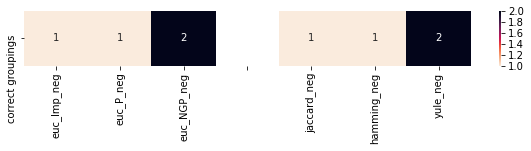

In [48]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

In [49]:
#f, ax = plt.subplots(figsize=(20, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### K-means clustering

In [50]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering and how samples are separated 
Use of the module do sci-kit learn - sklearn. Cluster number equal to the amount of varieties. How well can this method separate the varieties. Default parameters except number of clusters.

This example doesn't necessarily mirror the results below (for the case in example) since K-means clustering has an intrinsically random side to it and the clustering is performed again for the case example.

In [51]:
Kmean = skclust.KMeans(n_clusters=5)

In [52]:
a = Kmean.fit(Euc_NGP_neg.data.T)
a = Kmean.fit(aligned_neg.T)

In [53]:
dicto = {}
for i in range(len(a.labels_)):
    if a.labels_[i] in dicto:
        dicto[a.labels_[i]].append(aligned_HILIC_NEG.labels[i])
    else:
        dicto[a.labels_[i]] = [aligned_HILIC_NEG.labels[i]]
dicto

{0: ['Flower',
  'Flower',
  'Flower',
  'Flower',
  'Flower',
  'Flower',
  'Flower',
  'Flower'],
 4: ['Leaf', 'Leaf', 'Leaf', 'Leaf', 'Bulb', 'Leaf', 'Leaf'],
 2: ['Bulb',
  'Bulb',
  'Bulb',
  'Bulb',
  'Bulb',
  'Bulb',
  'Bulb',
  'Bulb',
  'Bulb',
  'Bulb'],
 3: ['Shoot',
  'Shoot',
  'Shoot',
  'Shoot',
  'Scape',
  'Scape',
  'Scape',
  'Scape',
  'Scape',
  'Scape',
  'Scape',
  'Scape'],
 1: ['Bulb', 'Bulb', 'Bulb', 'Bulb']}

### K-means clustering applied to all euclidean methods and the binary matrixes built

To try and get a condensed and more easily digestible version of the results, a method similar to the discrimination distance performed in the hierarchical clustering was made. The same metrics as before are used.

Replicates of a variety can be together in a cluster but, if there are more samples in the same cluster, its "discrimination distance" is still zero. Therefore, this method is harsher than the original dist_discrim method. The distance is calculated as the distance between the centroid of the cluster where the samples are and the closest centroid. This distance is normalized by dividing it by the maximum distance between any 2 centroids of the clusters formed. The mean/median of the discrimination distances of all groups is then a measure of the global discrimination distance

Use of the Kmeans_discrim function from multianalysis to calculate discrimination distance.

In [54]:
#aligned_neg2 = df_to_bool(aligned_all_neg2.data)
#aligned_pos2 = df_to_bool(aligned_all_pos2.data)

In [55]:
colnames2 = ['euc_Imp_neg', 'euc_P_neg', 'euc_NGP_neg', 'aligned_neg']

In [56]:
euclidean = (Imputated_neg, Euc_P_neg, Euc_NGP_neg)#, 
binaries = (aligned_neg)

In [57]:
from metabolinks import AlignedSpectra

In [58]:
disc_average = np.zeros((1,4))
disc_median = np.zeros((1,4))
disc_correct = np.zeros((1,4))
for i in range(len(euclidean)):
    discrim = ma.Kmeans_discrim(euclidean[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.Kmeans_discrim(euclidean[i], method = 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])

discrim = ma.Kmeans_discrim(AlignedSpectra(aligned_neg, labels = aligned_HILIC_NEG.labels), method = 'average')
disc_average[0,3] 
disc_average[0,3] = discrim[0]
disc_median[0,3] = ma.Kmeans_discrim(AlignedSpectra(aligned_neg, labels = aligned_HILIC_NEG.labels), method = 'median')[0] 
correct = np.array(list(discrim[1].values()))
disc_correct[0,3] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames2)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames2)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames2)

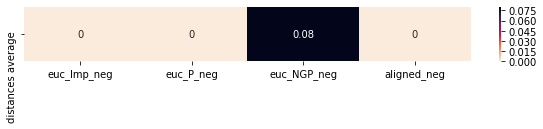

In [59]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.show()

In [60]:
#f, ax = plt.subplots(figsize=(10, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

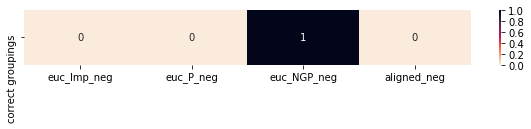

In [61]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### RandomForests Attempts - 3-fold cross-validation, n_estimators = 200

This section of the notebook takes some time.

In [62]:
#Creation of "binary" Spectras using the binary matrices built with the function df_to_bool.
binary_neg1 = AlignedSpectra(aligned_neg, labels = aligned_HILIC_NEG.labels)

In [63]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
#Vector with values for the parameter n_estimators
values = {}
values['n_estimators'] = range(10,450,10)
rf = skensemble.RandomForestClassifier(n_estimators = 200)
clf = GridSearchCV(rf, values, cv = 4)

In [64]:
param = []
test_score = []
for i in range(len(euclidean)):
    clf.fit(euclidean[i].data.T, euclidean[i].labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])

clf.fit(aligned_neg.T, Euc_P_neg.labels)
param.append(clf.cv_results_['param_n_estimators'])
test_score.append(clf.cv_results_['mean_test_score'])

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-pack

Performance based on number of trees, Negative Mode


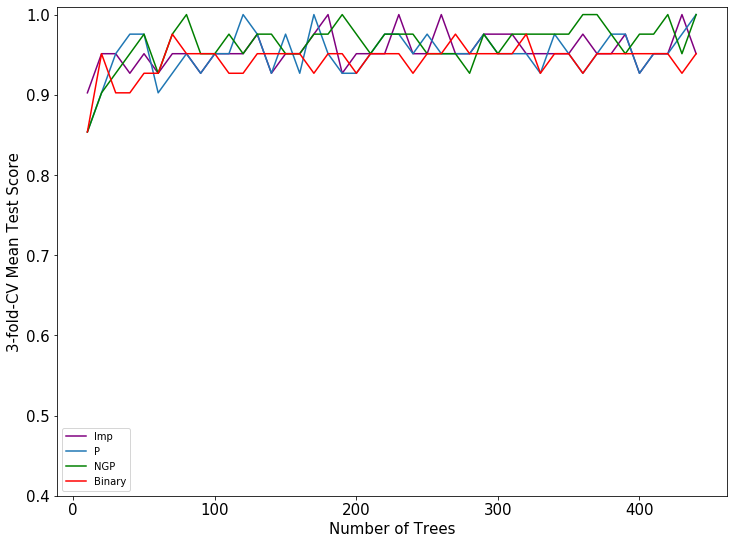

In [65]:
f, ax = plt.subplots(figsize=(12,9))
plt.plot(param[0], test_score[0], color = 'purple')
plt.plot(param[1], test_score[1])
plt.plot(param[2], test_score[2], color = 'green')
plt.plot(param[3], test_score[3], color = 'red')
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(('Imp', 'P', 'NGP', 'Binary'))
print('Performance based on number of trees, Negative Mode')

### Performance of N, NP and NGP data treatments (alignment 1-6)

See performance of all 3 treatments and absence of them in non-binary data to see which performs the best using method nº1 (simple application of random forests), see below.

In [66]:
Teste = {}
Teste_std = {}
Teste_feat = {}
N1_D = ma.simple_RF(Imputated_neg, n_fold = 4)#, iter_num = 100)#, n_trees = 500)
Teste['Imp_neg'] = np.mean(N1_D[0])
Teste_std['Imp_neg'] = np.std(N1_D[0])
Teste_feat['Imp_neg'] = N1_D[1]
N1_D = ma.simple_RF(Euc_P_neg, n_fold = 4)#, iter_num = 100)#, n_trees = 500)
Teste['P_neg'] = np.mean(N1_D[0])
Teste_std['P_neg'] = np.std(N1_D[0])
Teste_feat['P_neg'] = N1_D[1]
N1_D = ma.simple_RF(Euc_NGP_neg, n_fold = 4)#, iter_num = 100)#, n_trees = 500)
Teste['NGP_neg'] = np.mean(N1_D[0])
Teste_std['NGP_neg'] = np.std(N1_D[0])
Teste_feat['NGP_neg'] = N1_D[1]

BN1_D = ma.simple_RF(binary_neg1, n_fold = 4)#, iter_num = 100)#
Teste['bin_neg'] = np.mean(BN1_D[0])
Teste_std['bin_neg'] = np.std(BN1_D[0])
Teste_feat['bin_neg'] = BN1_D[1]

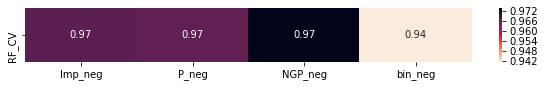

In [67]:
Teste_H = pd.DataFrame(list(Teste.values()), index = Teste.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Teste_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV'])

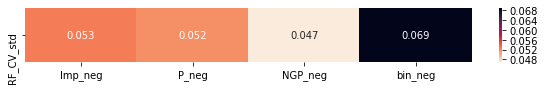

In [68]:
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Teste_std_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_std'])

In [69]:
Teste_H = pd.DataFrame(list(Teste.values()), index = Teste.keys(), columns = ['Accuracy']).T
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
Teste_ic = Teste_std_H / (100**0.5)*1.96

In [70]:
#sns.set_context('notebook')

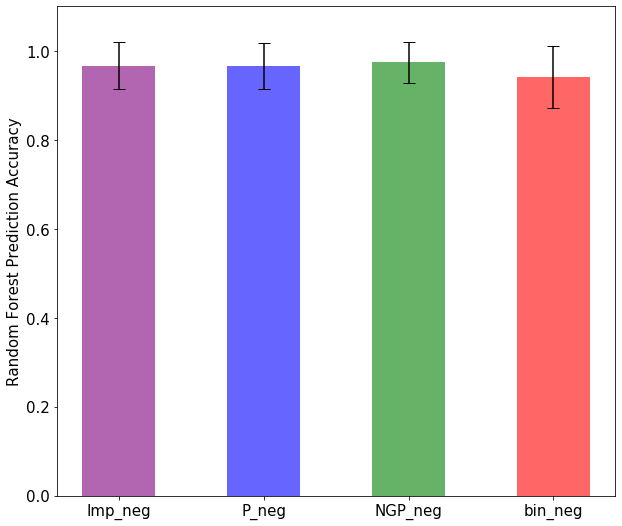

In [71]:
f, ax = plt.subplots(figsize=(10, 9))
#sns.set_context('talk')
color = ['purple','blue','green','red']
plt.bar(height = Teste_H.T['Accuracy'], x = Teste_H.columns, width = 0.5, color = color, alpha = 0.6)
ax.errorbar(x = Teste_H.columns, y = Teste_H.T['Accuracy'], yerr = Teste_std_H.iloc[0,:], 
            ls = 'none', ecolor = 'black', capsize = 6)
plt.ylim(0,1.10)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Random Forest Prediction Accuracy', fontsize = 15)
plt.show()

### Attempt/Method nº1 - Direct

### Simple application of random forests

The random forest classification is iterated iter_num times to make sure more combinations of training and test samples are used. Then, an average of the results are obtained. 

N-fold Cross-Validation is used as an internal validation system evaluating the performance of the model based on its score/prediction accuracy - the number of folds used will be the one that seems most appropriate in each case. For balanced datasets n_fold = number of replicates in each group if the number of replicates is under 10.

Besides the n-fold cross-validation score, the order of the average of most important features across the random forests (with each iteration and group in cross-validation having the same weight) is extracted from the forests "built".

Application of the function simple_RF from multianalysis.py.

### Characteristics of the features seen as important in the different alignments, data treatments and modes (negative and positive)

We take the 2% most important features in each case and calculate the average number of samples those features appear (samples_m), the average number of different groups/varieties those features appear in (groups_n) and the ratio between these two measures (ratio_m, has a maximum of 3). We also see how many times the importance of the most importante feature is greater than the average importance of a feature in each case ('magni') as well as the % of the model explained (that use) the 2% of the most important features ('more').

A scatter plot is also built to see the distributions of the number of samples each important feature in each method appears to see their overall distribution.

In [72]:
#Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature and calculating
#% explained by these features (more)
ev = []
magni = []
more = []
for j in Teste_feat:#['neg2-1_direct']:
    if j.endswith('neg'):
        #continue
        Spectra = aligned_HILIC_NEG
    elif j.endswith('pos'):
        Spectra = aligned_RP_POS
    ratio = []
    nsamples = []
    n_groups = []
    number = round(0.02*len(Spectra))
    magni.append(Teste_feat[j][0][1]/(1/len(Spectra)))
    a = 0
    for i in range(number): 
        a = a + Teste_feat[j][i][1]*100 
        ngroups = {}
        line = Spectra.data.loc[Teste_feat[j][i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    more.append(a)
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)
#print(ev[4])

In [73]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = [i  for i in Teste_feat])
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)


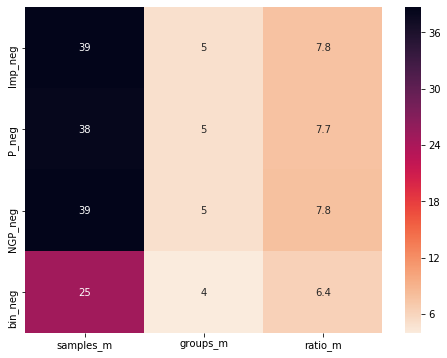

In [74]:
f, ax = plt.subplots(figsize=(8, 6))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

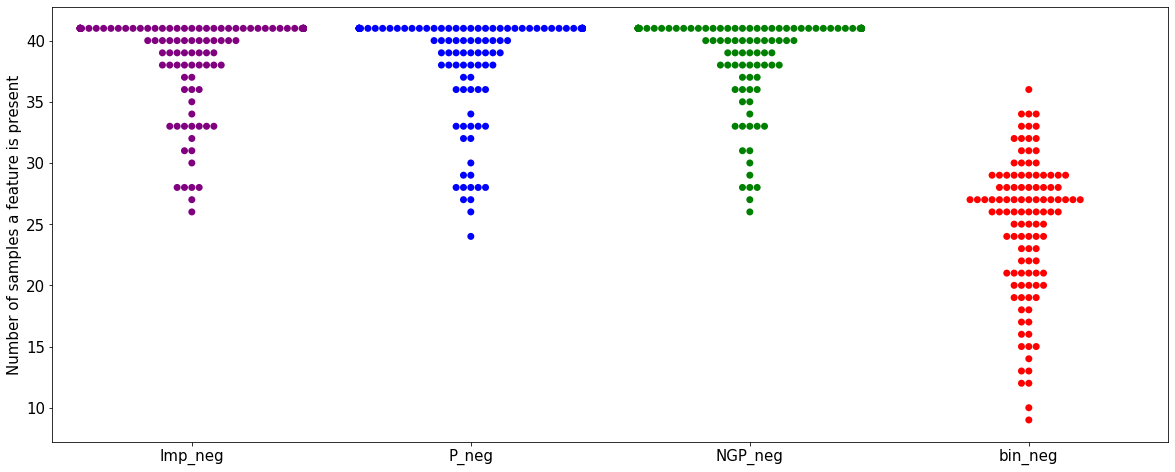

In [75]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data, size = 7, palette = ['purple','blue','green','red'])
ax.set(xticklabels = [list(Teste_feat.keys())[i][0:13] for i in range(len(Teste_feat.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [76]:
print('Magnitude of most important feature:', magni)
print('% of model explained by the 2% most important features', more)

Magnitude of most important feature: [14.791909997806178, 14.561624381280298, 14.390459351342804, 38.840792552232536]
% of model explained by the 2% most important features [18.18709206893328, 17.86469851925816, 18.106382203987458, 30.491075293650386]


### Permutation Tests - Random Forests

Permutation tests is based on shuffling the labels of the different samples, shuflling the groups where they belong with the intent to see if the classifier tested, whether it is random forests or pls-da found a significant class structure in the data. 

For that a random k-fold cross-validation is performed on the original dataset (to serve as a comparation point) and 150 permutations of datasets with labels randomly shuffled around with the model being evaluated by how good the predictions the model does of the test data is. 

Histograms with the prediction accuracy of the different permutations were plotted and compared to the accuracy got with the original dataset.

The empirical p-value is given by (the number of times the permutation accuracy was bigger than the random 3-fold cross-validation made with the original dataset + 1) / (number of permutations + 1) (source: Ojala2010 - error should be the opposite of the accuracy).

In [77]:
CV = {}
PMs = {}
pvalue = {}

In [78]:
permuta = ma.permutation_RF(Imputated_neg, iter_num = 150, n_fold = 4)
CV['Imp_neg'] = permuta[0]
PMs['Imp_neg'] = permuta[1]
pvalue['Imp_neg'] = permuta[2]

permuta = ma.permutation_RF(Euc_P_neg, iter_num = 150, n_fold = 4)
CV['P_neg'] = permuta[0]
PMs['P_neg'] = permuta[1]
pvalue['P_neg'] = permuta[2]

In [79]:
permuta = ma.permutation_RF(Euc_NGP_neg, iter_num = 150, n_fold = 4)
CV['NGP_neg'] = permuta[0]
PMs['NGP_neg'] = permuta[1]
pvalue['NGP_neg'] = permuta[2]

permuta = ma.permutation_RF(binary_neg1, iter_num = 150, n_fold = 4)
CV['bin_neg'] = permuta[0]
PMs['bin_neg'] = permuta[1]
pvalue['bin_neg'] = permuta[2]

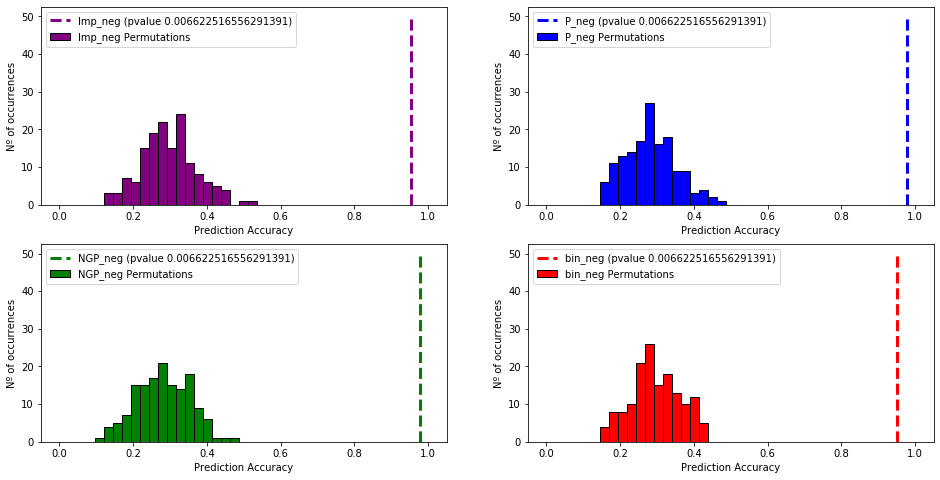

In [80]:
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['Imp_neg', 'P_neg', 'NGP_neg', 'bin_neg']
color = ['purple','blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

for i in range(len(Names)):
    quadrant[i].hist(PMs[Names[i]], len(Euc_NGP_neg.labels), range = (0,1.0001), label = Names[i] + ' Permutations',
             edgecolor='black', color = color[i])#, alpha = 0.3)
    
    quadrant[i].plot(2 * [CV[Names[i]]], ylim, '--g', linewidth=3, color = color[i], #alpha = 0.5,
             label=Names[i] +
             ' (pvalue %s)' % pvalue[Names[i]])
    quadrant[i].set(xlabel = 'Prediction Accuracy',ylabel = 'Nº of occurrences')
    quadrant[i].legend()

### PLS-DA - Classification based on Partial Least Squares - Discriminant Analysis

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong).

In [81]:
matrix = pd.get_dummies(aligned_HILIC_NEG.labels)
matrix = matrix[['Bulb','Leaf','Scape','Shoot','Flower']]

## Alignment 1-6

### Search for the best number of components to use

Strategy: Perform PLS-DA with different number of components and observe the score (both given directly by the method and the r2 score) and the mean-squared error (MSE) of the models built with 3-fold cross-validation (3 was chosen since it is the max for our dataset - 3 replicates in each group, having an added bonus of still maintaining a balanced dataset). Then plot the different results obtained and see at which point (number of components) the score and the MSE stops start approaching a "stable value".

The maximum number of components tested was 50 (which was enough for the objective established above).

Warnings are due to the type of scoring that will be changed in the next version of scikit learn.

Function optim_PLS in multianalysis.py - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp.

In [82]:
%%capture
#PLS applied in the negative dataset.
Imp_neg_PLS = ma.optim_PLS(Imputated_neg, matrix, max_comp = 20, n_fold = 4)
P_neg_PLS = ma.optim_PLS(Euc_P_neg, matrix, max_comp = 20, n_fold = 4)
NGP_neg_PLS = ma.optim_PLS(Euc_NGP_neg, matrix, max_comp = 20, n_fold = 4)
bin_neg_PLS = ma.optim_PLS(binary_neg1, matrix, max_comp = 20, n_fold = 4)

Performance based on number of components


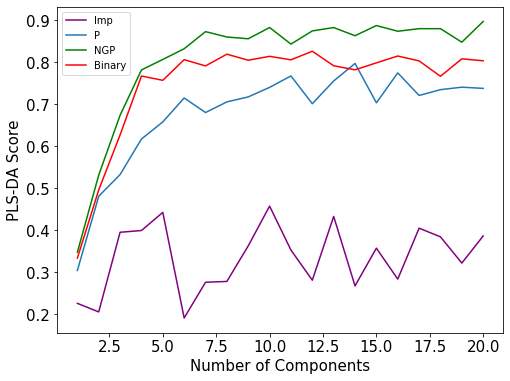

In [83]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,21),Imp_neg_PLS[0], color = 'purple')
plt.plot(range(1,21),P_neg_PLS[0])
plt.plot(range(1,21),NGP_neg_PLS[0], color = 'green')
plt.plot(range(1,21),bin_neg_PLS[0], color = 'red')
plt.ylabel('PLS-DA Score', fontsize = 15)
plt.xlabel('Number of Components', fontsize = 15)
ax.legend(('Imp', 'P', 'NGP', 'Binary'))
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of components')

### Application of PLS-DA

The number of components where the evaluating metrics stopped getting considerably better when it reached around 15. 

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule.

Two metrics to evaluate the results were evaluated. First the score of the model as seen before but more importantly the second one is the accuracy of the model based on the decision rule stated above. All samples are tested once in k different groups as k-fold cross-validation.

In [84]:
PLS_accu = {}
PLS_score = {}
PLS_weights = {}
PLS_RegCoef = {}

In [85]:
%%capture
Imp_neg_PLS = ma.model_PLSDA(Imputated_neg, matrix, n_comp = 8, iter_num = 100, n_fold = 4)
PLS_accu['Imp_neg'] = Imp_neg_PLS[0]
PLS_score['Imp_neg'] = Imp_neg_PLS[1]
PLS_weights['Imp_neg'] = Imp_neg_PLS[3]
PLS_RegCoef['Imp_neg'] = Imp_neg_PLS[4]

P_neg_PLS = ma.model_PLSDA(Euc_P_neg, matrix, n_comp = 8, iter_num = 100, n_fold = 4)
PLS_accu['P_neg'] = P_neg_PLS[0]
PLS_score['P_neg'] = P_neg_PLS[1]
PLS_weights['P_neg'] = P_neg_PLS[3]
PLS_RegCoef['P_neg'] = P_neg_PLS[4]

NGP_neg_PLS = ma.model_PLSDA(Euc_NGP_neg, matrix, n_comp = 8, iter_num = 100, n_fold = 4)
PLS_accu['NGP_neg'] = NGP_neg_PLS[0]
PLS_score['NGP_neg'] = NGP_neg_PLS[1]
PLS_weights['NGP_neg'] = NGP_neg_PLS[3]
PLS_RegCoef['NGP_neg'] = NGP_neg_PLS[4]

bin_neg_PLS = ma.model_PLSDA(binary_neg1, matrix, n_comp = 8, iter_num = 100, n_fold = 4)
PLS_accu['bin_neg'] = bin_neg_PLS[0]
PLS_score['bin_neg'] = bin_neg_PLS[1]
PLS_weights['bin_neg'] = bin_neg_PLS[3]
PLS_RegCoef['bin_neg'] = bin_neg_PLS[4]

Accuracy based on the dataset


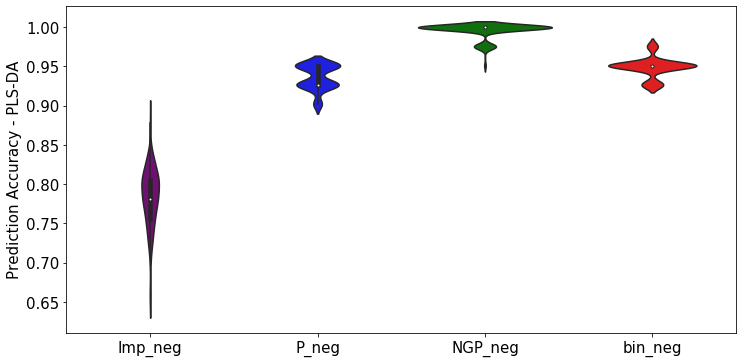

In [86]:
f, ax = plt.subplots(figsize=(12,6))
colors = ['purple','blue','green','red']
sns.violinplot(data=pd.DataFrame.from_dict(PLS_accu), palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 15)
print('Accuracy based on the dataset')

Performance score based on the dataset


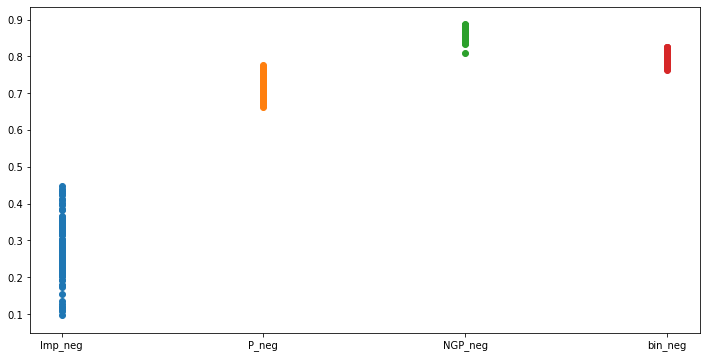

In [87]:
f, ax = plt.subplots(figsize=(12,6))
plt.scatter(['Imp_neg']*len(PLS_score['Imp_neg']), PLS_score['Imp_neg'])
plt.scatter(['P_neg']*len(PLS_score['P_neg']), PLS_score['P_neg'])
plt.scatter(['NGP_neg']*len(PLS_score['NGP_neg']), PLS_score['NGP_neg'])
plt.scatter(['bin_neg']*len(PLS_score['bin_neg']), PLS_score['bin_neg'])
##plt.ylabel('PLS-DA Model Score')
print('Performance score based on the dataset')

In [88]:
Accuracy = {}
Accuracy['Imp_neg'] = np.mean(PLS_accu['Imp_neg'])
Accuracy['P_neg'] = np.mean(PLS_accu['P_neg'])
Accuracy['NGP_neg'] = np.mean(PLS_accu['NGP_neg'])
Accuracy['bin_neg'] = np.mean(PLS_accu['bin_neg'])

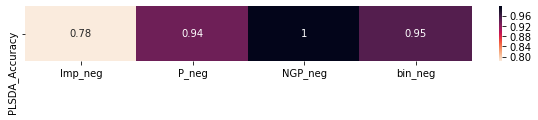

In [89]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])

In [90]:
Score = {}
Score['Imp_neg'] = np.mean(PLS_score['Imp_neg'])
Score['P_neg'] = np.mean(PLS_score['P_neg'])
Score['NGP_neg'] = np.mean(PLS_score['NGP_neg'])
Score['bin_neg'] = np.mean(PLS_score['bin_neg'])

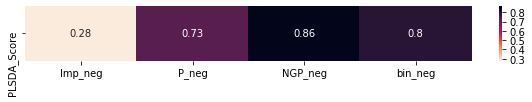

In [91]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Score_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Score'])

In [92]:
Accuracy_std = {}
Accuracy_std['Imp_neg'] = np.std(PLS_accu['Imp_neg'])
Accuracy_std['P_neg'] = np.std(PLS_accu['P_neg'])
Accuracy_std['NGP_neg'] = np.std(PLS_accu['NGP_neg'])
Accuracy_std['bin_neg'] = np.std(PLS_accu['bin_neg'])

In [93]:
Score_std = {}
Score_std['Imp_neg'] = np.std(PLS_score['Imp_neg'])
Score_std['P_neg'] = np.std(PLS_score['P_neg'])
Score_std['NGP_neg'] = np.std(PLS_score['NGP_neg'])
Score_std['bin_neg'] = np.std(PLS_score['bin_neg'])

In [94]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys(), columns  = ['Accuracy']).T
Accuracy_H.loc['SD'] = list(Accuracy_std.values())
Accuracy_H.T

,Accuracy,SD
Imp_neg,0.783902,0.036180
P_neg,0.936098,0.015724
NGP_neg,0.996098,0.009584
bin_neg,0.949024,0.012482


In [95]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys(), columns  = ['Score']).T
Score_H.loc['SD'] = list(Score_std.values())
Score_H.T

,Score,SD
Imp_neg,0.280397,0.078821
P_neg,0.728493,0.024946
NGP_neg,0.864242,0.012572
bin_neg,0.801003,0.013221


### Characteristics of the most important features

The characteristics of the most important features for each of the methods is done by the same process as applied in the random forests section of the notebook.

In [96]:
#Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature 
Imp_feat = (PLS_weights, PLS_RegCoef)
ev = []
magni = []
index = []
for m in Imp_feat:
    for j in m:
        if j.endswith('neg'):
            Spectra = aligned_HILIC_NEG
        elif j.endswith('pos'):
            Spectra = aligned_RP_POS
        index.append(j)
        ratio = []
        nsamples = []
        n_groups = []
        number = round(0.02*len(Spectra))
        total_m = 0
        for i in range(len(m[j])):
            total_m = total_m + m[j][i][1]
        magni.append(m[j][0][1]/(total_m/len(Spectra)))
        for i in range(number): 
            ngroups = {}
            line = Spectra.data.loc[m[j][i][2],:].notnull()
            nsamples.append(line.sum())
            for n in range(len(line)):
                if line[n] == True:
                    ngroups[Spectra.labels[n]] = 1
            n_groups.append(sum(list((ngroups.values()))))
            ratio.append(nsamples[-1]/n_groups[-1])
        df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
        df['nsamples'] = nsamples
        df['n_groups'] = n_groups
        df['ratio']  = ratio
        ev.append(df)

In [97]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = index)
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:4], line, df.iloc[4:]])

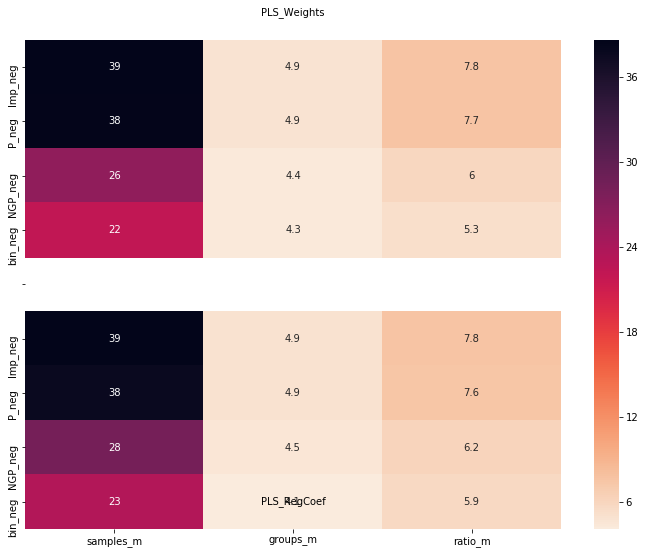

In [98]:
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.5,'PLS_Weights',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,8.5,'PLS_RegCoef',horizontalalignment='center', verticalalignment='center')
plt.show()

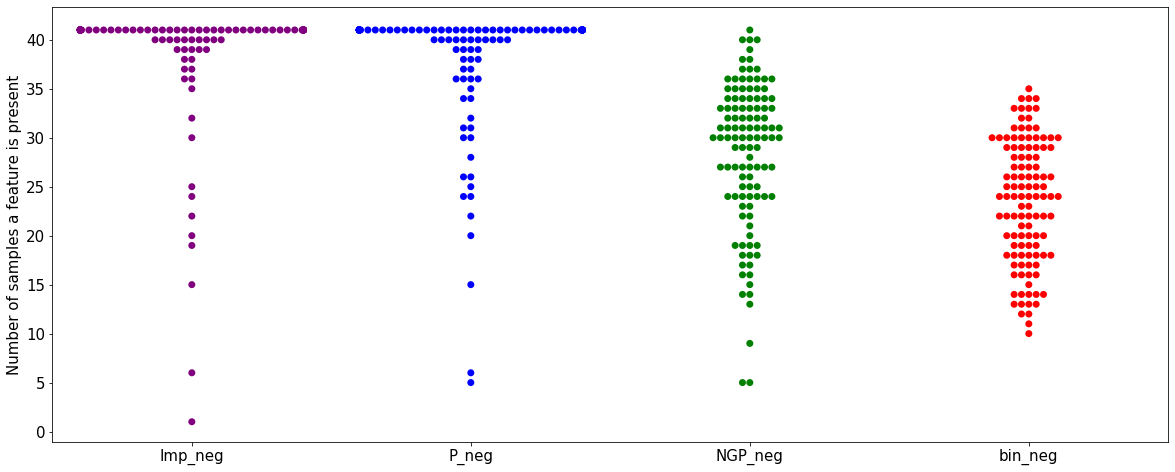

In [99]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data[4:], size = 7, palette = ['purple','blue','green','red'])
ax.set(xticklabels = [list(PLS_weights.keys())[i][0:13] for i in range(len(PLS_weights.keys()))][:4])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [100]:
print('Magnitude of most important features for each case:')
print(magni)

Magnitude of most important features for each case:
[88.04842375250054, 17.60188642490958, 2.427631547170639, 4.210543790033321, 66.26742954770415, 18.781323421667455, 4.177660440840053, 6.796096891882485]


### Model with the full dataset and sample representation on the two most important Components/Latent Variables

NGP data treatment for the negative mode

In [101]:
from sklearn.cross_decomposition import PLSRegression

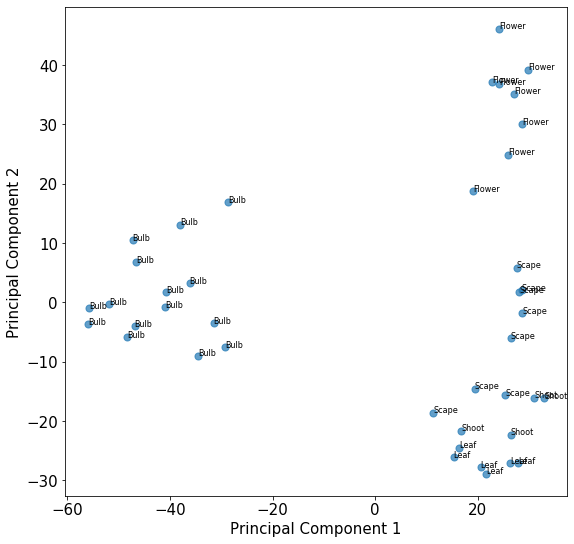

In [102]:
plsda = PLSRegression(n_components = 10)
#Fitting the model and getting the X_scores
plsda.fit(X=Euc_NGP_neg.data.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 4)
col_lbl = colours(range(4))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 9*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])
    col_lbl.insert(a+3,col_lbl[a])
    col_lbl.insert(a+4,col_lbl[a])
    col_lbl.insert(a+5,col_lbl[a])
    col_lbl.insert(a+6,col_lbl[a])
    col_lbl.insert(a+7,col_lbl[a])
    col_lbl.insert(a+8,col_lbl[a])

    #Scatter plot
ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7,  figsize=(9,9))#c = col_lbl,
ax.set_xlabel(xlabel = 'Principal Component 1', size = 15)
ax.set_ylabel(ylabel = 'Principal Component 2', size = 15)
ax.tick_params(axis='both', which='major', labelsize = 15)
#Labeling each point
i = -1
for n, x in enumerate(LV_score.values): 
    i = i + 1
    label = Spectra.labels[i]
                #label = LV_score.index.values[n]
    ax.text(x[0],x[1],label, fontsize = 8)

Binary processed data for the negative mode

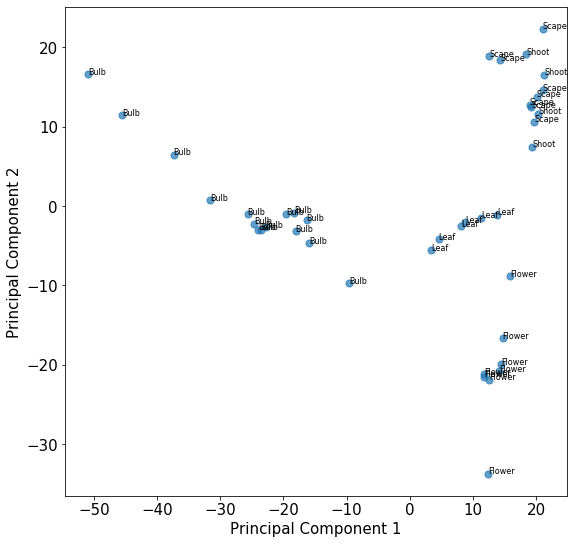

In [103]:
plsda = PLSRegression(n_components = 10)
#Fitting the model and getting the X_scores
plsda.fit(X=binary_neg1.data.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 4)
col_lbl = colours(range(4))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 9*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])
    col_lbl.insert(a+3,col_lbl[a])
    col_lbl.insert(a+4,col_lbl[a])
    col_lbl.insert(a+5,col_lbl[a])
    col_lbl.insert(a+6,col_lbl[a])
    col_lbl.insert(a+7,col_lbl[a])
    col_lbl.insert(a+8,col_lbl[a])

    #Scatter plot
ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, figsize=(9,9))#, c = col_lbl
ax.set_xlabel(xlabel = 'Principal Component 1', size = 15)
ax.set_ylabel(ylabel = 'Principal Component 2', size = 15)
ax.tick_params(axis='both', which='major', labelsize = 15)
#Labeling each point
i = -1
for n, x in enumerate(LV_score.values): 
    i = i + 1
    label = Spectra.labels[i]
                #label = LV_score.index.values[n]
    ax.text(x[0],x[1],label, fontsize = 8)

### Permutation Tests - PLS-DA

Same explanation as presented for Permutation Tests - Random Forests

In [104]:
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

In [105]:
permuta = ma.permutation_PLSDA(Imputated_neg, n_comp = 8, iter_num = 150, n_fold = 4)
CV_PLS['Imp_neg'] = permuta[0]
PMs_PLS['Imp_neg'] = permuta[1]
pvalue_PLS['Imp_neg'] = permuta[2]

permuta = ma.permutation_PLSDA(Euc_P_neg, n_comp = 8, iter_num = 150, n_fold = 4)
CV_PLS['P_neg'] = permuta[0]
PMs_PLS['P_neg'] = permuta[1]
pvalue_PLS['P_neg'] = permuta[2]

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


In [106]:
permuta = ma.permutation_PLSDA(Euc_NGP_neg, n_comp = 8, iter_num = 150, n_fold = 4)
CV_PLS['NGP_neg'] = permuta[0]
PMs_PLS['NGP_neg'] = permuta[1]
pvalue_PLS['NGP_neg'] = permuta[2]

permuta = ma.permutation_PLSDA(binary_neg1, n_comp = 8, iter_num = 150, n_fold = 4)
CV_PLS['bin_neg'] = permuta[0]
PMs_PLS['bin_neg'] = permuta[1]
pvalue_PLS['bin_neg'] = permuta[2]

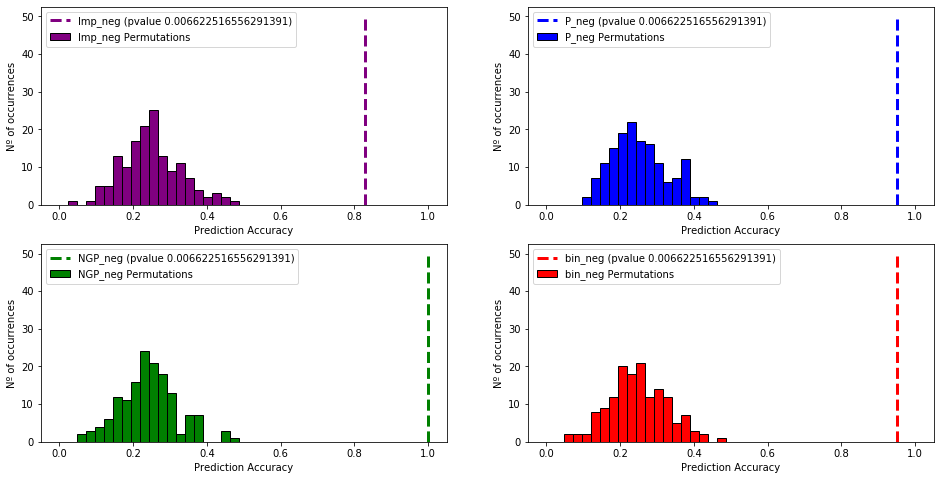

In [107]:
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['Imp_neg', 'P_neg', 'NGP_neg', 'bin_neg']
color = ['purple','blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

for i in range(len(Names)):
    quadrant[i].hist(PMs_PLS[Names[i]], len(Euc_NGP_neg.labels), range = (0,1.0001), label = Names[i] + ' Permutations',
             edgecolor='black', color = color[i])#, alpha = 0.3)
    
    quadrant[i].plot(2 * [CV_PLS[Names[i]]], ylim, '--g', linewidth=3, color = color[i], #alpha = 0.5,
             label=Names[i] +
             ' (pvalue %s)' % pvalue_PLS[Names[i]])
    quadrant[i].set(xlabel = 'Prediction Accuracy',ylabel = 'Nº of occurrences')
    quadrant[i].legend()